<a href="https://colab.research.google.com/github/WillKWL/Project-NBASeason/blob/master/2_ML_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
# remove library not used
import pandas as pd
import numpy as np
import numpy as np
import re
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = [20, 5]
from matplotlib.pyplot import figure
import copy
from tqdm import tqdm
import seaborn as sns

# packages for data_preparation pipeline
from scipy.stats import zscore
from matplotlib.patches import Rectangle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.decomposition import PCA 
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline, Pipeline

# packages for classification algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier

# packages for model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

# packages for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

# packages for loading and dumping models
from google.colab import drive, files
import os
from joblib import dump, load

# packages for ensemble learning
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier

In [2]:
# def warn(*args, **kwargs):
#     pass
# import warnings
# warnings.warn = warn

# Read train set

In [3]:
train_set = pd.read_pickle("https://github.com/WillKWL/PublicData/blob/main/raw/nba_pre_all_star_vs_playoff_train.pkl?raw=true")
train_set

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,PLAYOFF_RANKING,SEASON,UNIQUE_ID
0,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,10,Chicago Bulls,38.1,88.0,0.433,6.0,18.7,0.318,16.6,22.8,0.727,14.4,29.9,44.3,20.8,17.9,7.9,3.8,4.1,23.0,21.2,98.8,1,1996-97,1610612741199697
1,1610612737,Atlanta Hawks,46,31,15,0.674,54.8,38.2,87.1,0.438,8.9,24.8,0.360,20.1,26.4,0.760,14.1,33.3,47.5,20.1,16.7,8.6,6.1,4.6,21.8,0.1,105.4,5.8,10,Atlanta Hawks,38.7,90.4,0.428,6.8,19.9,0.342,15.4,21.3,0.722,14.8,31.4,46.2,23.3,16.8,8.0,4.6,6.1,24.2,21.8,99.6,0,1996-97,1610612737199697
2,1610612750,Minnesota Timberwolves,48,23,25,0.479,52.1,38.0,85.1,0.447,4.7,13.8,0.343,22.0,29.2,0.756,13.5,29.9,43.4,23.3,16.8,8.4,7.7,5.9,24.3,0.2,102.9,-2.2,10,Minnesota Timberwolves,38.8,85.6,0.453,6.1,16.4,0.370,21.4,29.0,0.739,14.2,31.3,45.5,23.5,17.7,8.3,5.9,7.7,24.4,24.3,105.0,0,1996-97,1610612750199697
4,1610612762,Utah Jazz,47,33,14,0.702,53.0,40.6,83.0,0.490,4.4,12.2,0.362,22.7,29.9,0.759,11.8,32.3,44.1,28.2,17.0,9.7,5.1,5.2,26.6,0.3,108.4,7.1,10,Utah Jazz,35.6,82.3,0.432,6.8,20.1,0.337,23.3,31.4,0.744,12.8,29.5,42.3,21.2,17.9,8.4,5.2,5.1,26.3,26.6,101.3,0,1996-97,1610612762199697
5,1610612761,Toronto Raptors,46,17,29,0.370,52.3,36.9,86.0,0.429,8.1,22.0,0.366,19.3,26.3,0.734,14.4,30.4,44.9,21.8,18.6,9.0,6.8,6.2,25.7,0.1,101.1,-3.9,10,Toronto Raptors,38.4,84.8,0.453,6.4,18.6,0.344,21.9,30.5,0.717,14.9,30.4,45.3,25.0,17.9,9.3,6.2,6.8,24.1,25.7,105.1,0,1996-97,1610612761199697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,1610612742,Dallas Mavericks,59,35,24,0.593,50.1,40.6,89.2,0.455,13.2,38.4,0.343,16.4,21.5,0.766,9.8,35.5,45.3,24.6,13.0,7.3,4.2,3.9,20.6,20.8,110.8,3.5,10,Dallas Mavericks,40.2,88.5,0.455,11.0,32.9,0.335,15.8,21.0,0.755,9.8,36.2,45.9,24.2,14.1,7.0,3.9,4.2,20.8,20.6,107.3,0,2021-22,1610612742202122
767,1610612739,Cleveland Cavaliers,58,35,23,0.603,49.5,40.8,87.6,0.466,12.1,34.3,0.353,16.2,21.5,0.755,10.6,35.6,46.3,26.0,15.3,7.4,4.4,4.6,17.5,19.9,110.0,4.3,10,Cleveland Cavaliers,39.8,90.2,0.442,11.7,34.5,0.340,14.3,18.8,0.758,11.2,33.5,44.7,23.8,14.3,8.9,4.6,4.4,19.9,17.5,105.7,0,2021-22,1610612739202122
768,1610612741,Chicago Bulls,59,38,21,0.644,48.4,42.4,87.7,0.483,11.3,30.0,0.376,17.4,21.3,0.817,9.0,34.7,43.7,24.6,13.1,7.1,4.5,5.1,18.7,17.7,113.4,2.3,10,Chicago Bulls,41.3,88.5,0.467,11.8,32.4,0.363,16.7,21.0,0.797,9.4,34.1,43.5,25.2,13.3,7.4,5.1,4.5,17.7,18.7,111.1,0,2021-22,1610612741202122
769,1610612766,Charlotte Hornets,60,29,31,0.483,47.5,41.2,90.2,0.456,13.4,37.6,0.356,15.5,21.0,0.737,10.8,33.3,44.1,26.6,13.0,8.5,4.7,4.8,19.5,19.3,111.3,-0.9,10,Charlotte Hornets,40.9,88.4,0.463,13.7,38.4,0.356,16.7,21.9,0.762,10.9,35.9,46.9,25.6,15.0,7.4,4.8,4.7,19.3,19.5,112.1,0,2021-22,1610612766202122


# Exploratory data analysis
- dataset set can be split into left and right half
- left half = team stats
- right half = team stats (ranked)
- Y = PLAYOFF_RANKING

In [4]:
pd.DataFrame(train_set.dtypes).T

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,PLAYOFF_RANKING,SEASON,UNIQUE_ID
0,object,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,category,category,object


In [5]:
train_set.describe()

,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,51.010545,25.277680,25.732865,0.496369,50.807206,39.177329,86.874692,0.451037,7.821793,22.021441,0.353483,18.958875,25.093322,0.756631,11.728295,33.116872,44.847979,23.043058,15.413005,7.991037,5.185237,5.230228,22.212478,15.284007,105.135149,-0.076626,39.201406,86.840949,0.451424,7.789807,21.911248,0.354608,19.020914,25.149385,0.756891,11.723902,33.162039,44.885062,23.072056,15.396309,8.030053,5.230228,5.185062,22.212654,22.212302,105.210896
std,6.095186,8.485709,8.734483,0.156774,1.984864,1.600593,2.162189,0.016853,2.799355,7.499584,0.022351,2.241564,3.087593,0.031409,1.742587,1.741487,1.900621,1.989176,1.479605,0.962066,0.953049,0.802286,2.285226,9.772402,4.505587,4.928410,1.665716,2.179512,0.015978,2.519110,6.838016,0.017344,2.278359,3.089858,0.017929,1.423640,1.716470,1.677032,1.701204,1.472974,0.786658,0.802286,0.953130,2.152614,2.285038,4.242191
min,30.000000,4.000000,4.000000,0.077000,45.500000,34.100000,81.000000,0.407000,2.400000,7.800000,0.279000,12.900000,17.900000,0.647000,7.500000,27.700000,37.600000,18.200000,11.100000,5.700000,2.400000,3.100000,16.900000,0.000000,89.500000,-15.500000,34.500000,79.800000,0.395000,3.900000,11.500000,0.298000,14.000000,18.400000,0.707000,8.100000,28.000000,40.200000,17.700000,11.600000,6.000000,3.100000,2.400000,17.700000,16.900000,91.800000
25%,49.000000,19.000000,19.000000,0.388000,49.300000,38.100000,85.400000,0.439000,5.800000,16.500000,0.339000,17.300000,22.700000,0.738000,10.600000,31.900000,43.700000,21.700000,14.300000,7.300000,4.500000,4.700000,20.500000,0.300000,102.300000,-3.300000,38.100000,85.400000,0.441000,5.900000,16.900000,0.342000,17.400000,22.900000,0.744000,10.700000,32.100000,43.800000,22.000000,14.400000,7.500000,4.700000,4.500000,20.600000,20.500000,102.500000
50%,52.000000,25.000000,25.000000,0.500000,51.000000,39.100000,87.100000,0.450000,7.300000,20.400000,0.354000,18.900000,25.200000,0.758000,11.700000,33.000000,44.900000,22.900000,15.400000,7.900000,5.100000,5.200000,22.100000,20.300000,104.700000,0.000000,39.300000,86.900000,0.453000,7.000000,19.700000,0.355000,18.900000,24.900000,0.757000,11.800000,33.100000,44.900000,23.000000,15.400000,8.000000,5.200000,5.100000,22.200000,22.100000,105.100000
75%,54.000000,32.000000,32.000000,0.611000,52.300000,40.300000,88.300000,0.462000,9.700000,26.900000,0.368000,20.500000,27.400000,0.778000,13.000000,34.300000,46.200000,24.400000,16.300000,8.600000,5.800000,5.700000,23.800000,22.200000,108.400000,3.300000,40.300000,88.300000,0.462000,9.400000,26.100000,0.366000,20.500000,27.200000,0.769000,12.700000,34.200000,46.000000,24.200000,16.400000,8.500000,5.700000,5.800000,23.800000,23.800000,108.100000
max,60.000000,48.000000,48.000000,0.923000,56.600000,43.700000,93.600000,0.508000,17.100000,45.300000,0.424000,26.100000,33.800000,0.844000,18.400000,40.100000,50.300000,30.500000,21.100000,11.600000,8.300000,8.000000,29.800000,28.500000,118.200000,13.900000,44.100000,93.200000,0.492000,15.600000,41.300000,0.426000,27.600000,36.100000,0.805000,16.000000,38.200000,50.500000,27.700000,20.100000,11.000000,8.000000,8.300000,28.500000,29.800000,116.600000


In [6]:
# explanatory variable (Y) = PLAYOFF_RANKING
# for some seasons, we don't have a champion becuz of train-test split
train_set.groupby(["SEASON"]).PLAYOFF_RANKING.value_counts().reset_index().pivot(index = "level_1", columns = "SEASON", values = "PLAYOFF_RANKING")

SEASON,1996-97,1999-00,2000-01,2001-02,2002-03,2003-04,2004-05,2005-06,2006-07,2007-08,2008-09,2009-10,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21,2021-22
level_1,,,,,,,,,,,,,,,,,,,,,,,,
0,24,22,23,25,22,23,24,22,22,23,20,21,23,23,21,23,26,24,23,21,23,24,25,23
1,1,1,0,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1


In [7]:
# no missing data
train_set.isna().sum()[train_set.isna().sum() != 0]

Series([], dtype: int64)

In [8]:
numeric_col = train_set.select_dtypes(include=np.number).columns.values.tolist()
print(f"number of numeric columns: {len(numeric_col)}")

number of numeric columns: 46


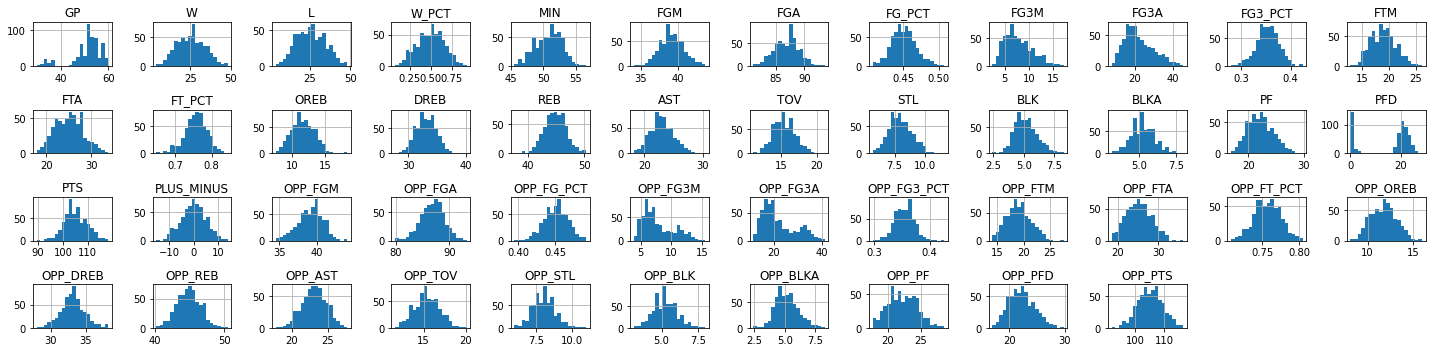

In [9]:
# plot distributions of each numeric column
# rank of each variable will exhibit uniform distribution
train_set.hist(bins=20, layout = (4, int(len(numeric_col) / 4) + 1))
plt.tight_layout()
plt.show()

## Outliers in PFD

In [11]:
# equivalent measure: PFD (# of fouls drawn) = OPP_PF (# of fouls committed by opponent)
# outlier: PFD (Personal Fouls Drawn) with a high frequency at 0 
train_set.PFD.value_counts(bins = np.linspace(train_set.PFD.min(), train_set.PFD.max(), 10, dtype=int)).sort_index()

(-0.001, 3.0]    163
(3.0, 6.0]         5
(6.0, 9.0]         0
(9.0, 12.0]        0
(12.0, 15.0]       0
(15.0, 19.0]      39
(19.0, 22.0]     215
(22.0, 25.0]     132
(25.0, 28.0]      14
Name: PFD, dtype: int64

In [12]:
# while OPP_PF (ie PFD) has a more even distribution
# consider replacing PFD with OPP_PF
train_set.OPP_PF.value_counts(bins = np.linspace(train_set.OPP_PF.min(), train_set.OPP_PF.max(), 10, dtype=int)).sort_index()

(16.999, 18.0]      8
(18.0, 20.0]       87
(20.0, 21.0]       96
(21.0, 22.0]       87
(22.0, 23.0]       86
(23.0, 24.0]       84
(24.0, 26.0]      100
(26.0, 27.0]       13
(27.0, 28.0]        6
Name: OPP_PF, dtype: int64

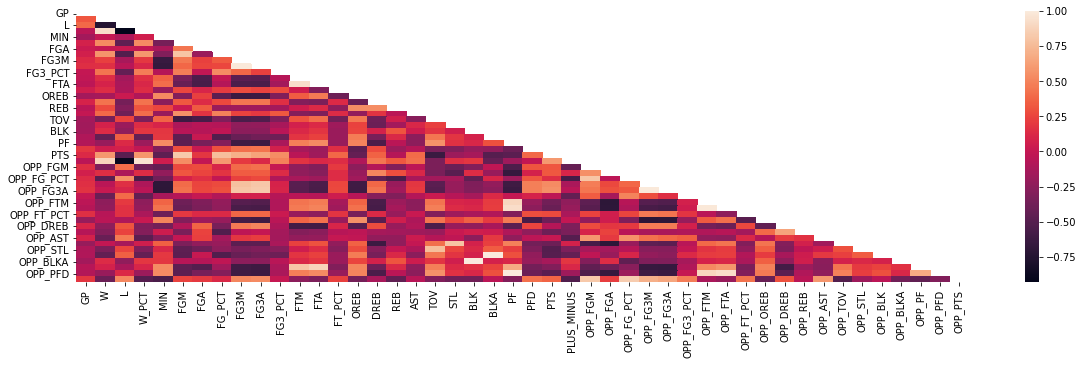

In [13]:
# normal observations:
## positive correlation between Wins and Plus Minus (net of points scored and lost per 100 posessions)
## negative correlation between FGM, FGA vs defensive stats (STL, BLK, PF) -> perhaps more effort on defensive end means less energy available on offensive end

# interesting observations:
## negative correlation between OREB and (FG3M, FG3A, FG3%) but not so much with FG -> missing shots lead to more OREB and fewer attempts
## positive correlation between DREB and (FG3M, FG3A, FG3%) but not so much with FG -> opponents missing shots lead to more risk taking in shooting 3 instead of 2
corr_mat = train_set.loc[:,numeric_col].corr()
sns.heatmap(corr_mat, 
            annot=False, 
            mask = np.triu(corr_mat)) # to show only lower triangle
plt.show()

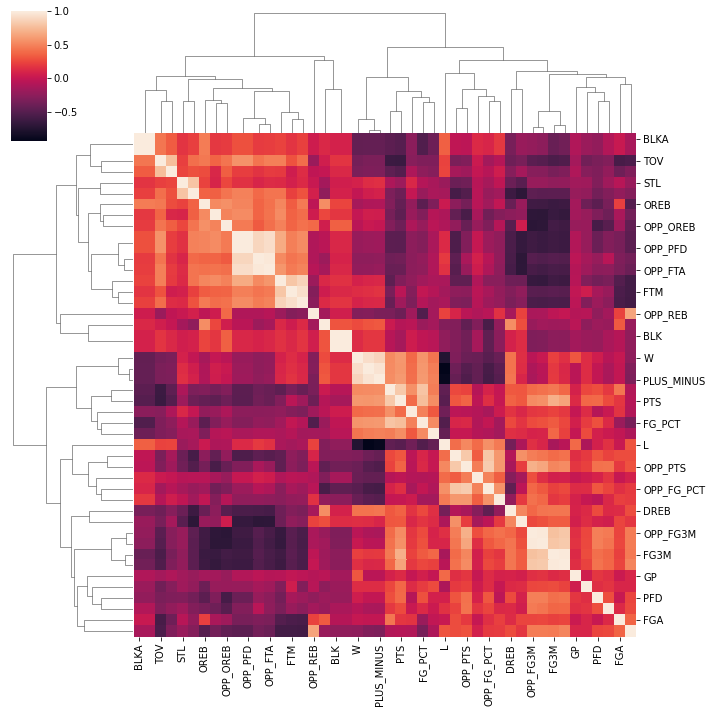

In [14]:
# use dendrogram to see clusters
sns.clustermap(corr_mat)

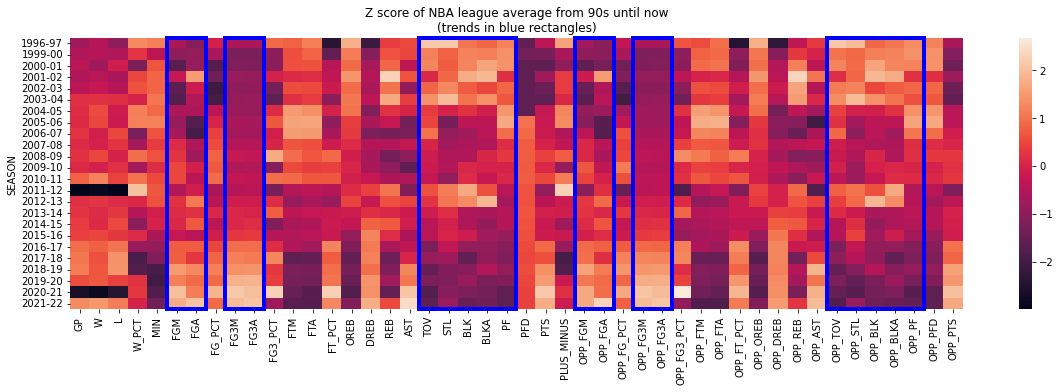

In [15]:
# it's often mentioned that NBA teams in different era play with different styles
# we have already adjusted the stats per possession so pace doesn't impact the numbers here
# in 90s, teams play more defense and are more physical (higher PF, BLK, STL, TOV)
# in recent era, teams shoot more 3s and score more points (FG and FG3)
# Feature engineering: clustering for SEASON to take into account this difference 
ax = sns.heatmap(train_set.loc[:,numeric_col + ["SEASON"]].groupby("SEASON").mean().apply(zscore))
plt.title("Z score of NBA league average from 90s until now\n(trends in blue rectangles)")
for col in [
    ("FGM", "FGA"), ("FG3M", "FG3A"), ("TOV", "STL", "BLK", "BLKA", "PF"),
    ("OPP_FGM", "OPP_FGA"), ("OPP_FG3M", "OPP_FG3A"), ("OPP_TOV", "OPP_STL", "OPP_BLK", "OPP_BLKA", "OPP_PF")
    ]:
  if len(col) > 1:
    ax.add_patch(Rectangle((numeric_col.index(col[0]), 0), len(col), len(train_set.SEASON.unique()), fill=False, edgecolor="blue", lw=4, clip_on=False))
  else:
    ax.add_patch(Rectangle((numeric_col.index(col), 0), 1, len(train_set.SEASON.unique()), fill=False, edgecolor="blue", lw=4, clip_on=False))
plt.show()

# check sklearn feature_selection

# Data preparation
- Over/Under-sampling to reduce imbalance in data
  - data set is highly imbalanced with only 1 out of 30 NBA teams winning the championship each year
  - however, over-sampling the champions may exacerbate the bias in our small sample
  - there is not enough data to under-sample as well
  - therefore let's keep it as is and use confusion matrix to measure performance accordingly
- Data cleaning
  - Remove outlier seasons in terms of GP (Games Played)
  - Fix PFD column with OPP_PF column
  - Drop irrelevant columns, e.g. GP (Games Played) is 82 for most seasons and stats are already normalized per 100 possessions
  - Feature scaling
    - Transform numeric variables by normal quantiles 
  
- Feature engineering
  - Cluster similar seasons together with KMeans to represent different NBA eras
  - Add column "FG2A" = "FGA" - "FG3A" and "FG2M" = "FGM" - "FG3M"
  - Add column "FG2A"/"FG3A" to represent % of 2-point shots taken vs 3-point shots taken

- Dimensionality reduction
  - PCA to speed up random forest and fix axis orientation issue with decision tree

- Feature selection
  - Use random forest to drop useless features

In [16]:
# make a copy and split X and y
season = train_set.drop(columns = "PLAYOFF_RANKING").reset_index(drop = True).copy(deep = True)
season_label = train_set[["PLAYOFF_RANKING"]].values.reshape(-1,)

In [17]:
# X_train before data preparation
season

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,SEASON,UNIQUE_ID
0,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,10,Chicago Bulls,38.1,88.0,0.433,6.0,18.7,0.318,16.6,22.8,0.727,14.4,29.9,44.3,20.8,17.9,7.9,3.8,4.1,23.0,21.2,98.8,1996-97,1610612741199697
1,1610612737,Atlanta Hawks,46,31,15,0.674,54.8,38.2,87.1,0.438,8.9,24.8,0.360,20.1,26.4,0.760,14.1,33.3,47.5,20.1,16.7,8.6,6.1,4.6,21.8,0.1,105.4,5.8,10,Atlanta Hawks,38.7,90.4,0.428,6.8,19.9,0.342,15.4,21.3,0.722,14.8,31.4,46.2,23.3,16.8,8.0,4.6,6.1,24.2,21.8,99.6,1996-97,1610612737199697
2,1610612750,Minnesota Timberwolves,48,23,25,0.479,52.1,38.0,85.1,0.447,4.7,13.8,0.343,22.0,29.2,0.756,13.5,29.9,43.4,23.3,16.8,8.4,7.7,5.9,24.3,0.2,102.9,-2.2,10,Minnesota Timberwolves,38.8,85.6,0.453,6.1,16.4,0.370,21.4,29.0,0.739,14.2,31.3,45.5,23.5,17.7,8.3,5.9,7.7,24.4,24.3,105.0,1996-97,1610612750199697
3,1610612762,Utah Jazz,47,33,14,0.702,53.0,40.6,83.0,0.490,4.4,12.2,0.362,22.7,29.9,0.759,11.8,32.3,44.1,28.2,17.0,9.7,5.1,5.2,26.6,0.3,108.4,7.1,10,Utah Jazz,35.6,82.3,0.432,6.8,20.1,0.337,23.3,31.4,0.744,12.8,29.5,42.3,21.2,17.9,8.4,5.2,5.1,26.3,26.6,101.3,1996-97,1610612762199697
4,1610612761,Toronto Raptors,46,17,29,0.370,52.3,36.9,86.0,0.429,8.1,22.0,0.366,19.3,26.3,0.734,14.4,30.4,44.9,21.8,18.6,9.0,6.8,6.2,25.7,0.1,101.1,-3.9,10,Toronto Raptors,38.4,84.8,0.453,6.4,18.6,0.344,21.9,30.5,0.717,14.9,30.4,45.3,25.0,17.9,9.3,6.2,6.8,24.1,25.7,105.1,1996-97,1610612761199697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1610612742,Dallas Mavericks,59,35,24,0.593,50.1,40.6,89.2,0.455,13.2,38.4,0.343,16.4,21.5,0.766,9.8,35.5,45.3,24.6,13.0,7.3,4.2,3.9,20.6,20.8,110.8,3.5,10,Dallas Mavericks,40.2,88.5,0.455,11.0,32.9,0.335,15.8,21.0,0.755,9.8,36.2,45.9,24.2,14.1,7.0,3.9,4.2,20.8,20.6,107.3,2021-22,1610612742202122
565,1610612739,Cleveland Cavaliers,58,35,23,0.603,49.5,40.8,87.6,0.466,12.1,34.3,0.353,16.2,21.5,0.755,10.6,35.6,46.3,26.0,15.3,7.4,4.4,4.6,17.5,19.9,110.0,4.3,10,Cleveland Cavaliers,39.8,90.2,0.442,11.7,34.5,0.340,14.3,18.8,0.758,11.2,33.5,44.7,23.8,14.3,8.9,4.6,4.4,19.9,17.5,105.7,2021-22,1610612739202122
566,1610612741,Chicago Bulls,59,38,21,0.644,48.4,42.4,87.7,0.483,11.3,30.0,0.376,17.4,21.3,0.817,9.0,34.7,43.7,24.6,13.1,7.1,4.5,5.1,18.7,17.7,113.4,2.3,10,Chicago Bulls,41.3,88.5,0.467,11.8,32.4,0.363,16.7,21.0,0.797,9.4,34.1,43.5,25.2,13.3,7.4,5.1,4.5,17.7,18.7,111.1,2021-22,1610612741202122
567,1610612766,Charlotte Hornets,60,29,31,0.483,47.5,41.2,90.2,0.456,13.4,37.6,0.356,15.5,21.0,0.737,10.8,33.3,44.1,26.6,13.0,8.5,4.7,4.8,19.5,19.3,111.3,-0.9,10,Charlotte Hornets,40.9,88.4,0.463,13.7,38.4,0.356,16.7,21.9,0.762,10.9,35.9,46.9,25.6,15.0,7.4,4.8,4.7,19.3,19.5,112.1,2021-22,1610612766202122


In [18]:
# y_train before data preparation
season_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Feature engineering - NewColumn
- Before data cleaning
- Add column "FG2A" = "FGA" - "FG3A" and "FG2M" = "FGM" - "FG3M"
- Add column "FG2A"/"FG3A" to represent % of 2-point shots taken vs 3-point shots taken

In [19]:
# create a custom transformer to perform numerical operations on columns 
# FunctionTransformer cannot be used in pipeline since the version in Google Colab does not support passing feature names in
class NewColumn(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    # 2 Point Field Goals Attempted = All Field Goals Attempted - 3 Point Field Goals Attempted
    output = copy.deepcopy(X)
    output['FG2A'] = output['FGA'] - output['FG3A']
    # 2 Point Field Goals Made
    output['FG2M'] = output['FGM'] - output['FG3M']
    # Percentage of 2 Point Field Goals Made
    output['FG2_PCT'] = output['FG2M'] / output['FG2A']
    # Ratio of 2 Point Field Goals Attempted to 3 Point Field Goals Attempted
    output['FG2_FG3'] = output['FG2A'] / output['FG3A']
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

In [20]:
NewColumn().fit_transform(season)

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PF,OPP_PFD,OPP_PTS,SEASON,UNIQUE_ID,FG2A,FG2M,FG2_PCT,FG2_FG3
0,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,10,Chicago Bulls,38.1,88.0,0.433,6.0,18.7,0.318,16.6,22.8,0.727,14.4,29.9,44.3,20.8,17.9,7.9,3.8,4.1,23.0,21.2,98.8,1996-97,1610612741199697,73.1,36.6,0.500684,3.867725
1,1610612737,Atlanta Hawks,46,31,15,0.674,54.8,38.2,87.1,0.438,8.9,24.8,0.360,20.1,26.4,0.760,14.1,33.3,47.5,20.1,16.7,8.6,6.1,4.6,21.8,0.1,105.4,5.8,10,Atlanta Hawks,38.7,90.4,0.428,6.8,19.9,0.342,15.4,21.3,0.722,14.8,31.4,46.2,23.3,16.8,8.0,4.6,6.1,24.2,21.8,99.6,1996-97,1610612737199697,62.3,29.3,0.470305,2.512097
2,1610612750,Minnesota Timberwolves,48,23,25,0.479,52.1,38.0,85.1,0.447,4.7,13.8,0.343,22.0,29.2,0.756,13.5,29.9,43.4,23.3,16.8,8.4,7.7,5.9,24.3,0.2,102.9,-2.2,10,Minnesota Timberwolves,38.8,85.6,0.453,6.1,16.4,0.370,21.4,29.0,0.739,14.2,31.3,45.5,23.5,17.7,8.3,5.9,7.7,24.4,24.3,105.0,1996-97,1610612750199697,71.3,33.3,0.467041,5.166667
3,1610612762,Utah Jazz,47,33,14,0.702,53.0,40.6,83.0,0.490,4.4,12.2,0.362,22.7,29.9,0.759,11.8,32.3,44.1,28.2,17.0,9.7,5.1,5.2,26.6,0.3,108.4,7.1,10,Utah Jazz,35.6,82.3,0.432,6.8,20.1,0.337,23.3,31.4,0.744,12.8,29.5,42.3,21.2,17.9,8.4,5.2,5.1,26.3,26.6,101.3,1996-97,1610612762199697,70.8,36.2,0.511299,5.803279
4,1610612761,Toronto Raptors,46,17,29,0.370,52.3,36.9,86.0,0.429,8.1,22.0,0.366,19.3,26.3,0.734,14.4,30.4,44.9,21.8,18.6,9.0,6.8,6.2,25.7,0.1,101.1,-3.9,10,Toronto Raptors,38.4,84.8,0.453,6.4,18.6,0.344,21.9,30.5,0.717,14.9,30.4,45.3,25.0,17.9,9.3,6.2,6.8,24.1,25.7,105.1,1996-97,1610612761199697,64.0,28.8,0.450000,2.909091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1610612742,Dallas Mavericks,59,35,24,0.593,50.1,40.6,89.2,0.455,13.2,38.4,0.343,16.4,21.5,0.766,9.8,35.5,45.3,24.6,13.0,7.3,4.2,3.9,20.6,20.8,110.8,3.5,10,Dallas Mavericks,40.2,88.5,0.455,11.0,32.9,0.335,15.8,21.0,0.755,9.8,36.2,45.9,24.2,14.1,7.0,3.9,4.2,20.8,20.6,107.3,2021-22,1610612742202122,50.8,27.4,0.539370,1.322917
565,1610612739,Cleveland Cavaliers,58,35,23,0.603,49.5,40.8,87.6,0.466,12.1,34.3,0.353,16.2,21.5,0.755,10.6,35.6,46.3,26.0,15.3,7.4,4.4,4.6,17.5,19.9,110.0,4.3,10,Cleveland Cavaliers,39.8,90.2,0.442,11.7,34.5,0.340,14.3,18.8,0.758,11.2,33.5,44.7,23.8,14.3,8.9,4.6,4.4,19.9,17.5,105.7,2021-22,1610612739202122,53.3,28.7,0.538462,1.553936
566,1610612741,Chicago Bulls,59,38,21,0.644,48.4,42.4,87.7,0.483,11.3,30.0,0.376,17.4,21.3,0.817,9.0,34.7,43.7,24.6,13.1,7.1,4.5,5.1,18.7,17.7,113.4,2.3,10,Chicago Bulls,41.3,88.5,0.467,11.8,32.4,0.363,16.7,21.0,0.797,9.4,34.1,43.5,25.2,13.3,7.4,5.1,4.5,17.7,18.7,111.1,2021-22,1610612741202122,57.7,31.1,0.538995,1.923333
567,1610612766,Charlotte Hornets,60,29,31,0.483,47.5,41.2,90.2,0.456,13.4,37.6,0.356,15.5,21.0,0.737,10.8,33.3,44.1,26.6,13.0,8.5,4.7,4.8,19.5,19.3,111.3,-0.9,10,Charlotte Hornets,40.9,88.4,0.463,13.7,38.4,0.356,16.7,21.9,0.762,10.9,35.9,46.9,25.6,15.0,7.4,4.8,4.7,19.3,19.5,112.1,2021-22,1610612766202122,52.6,27.8,0.528517,1.398936


## Feature scaling - num_pipeline
- Custom transformers to fix and drop columns
- Scale numeric features by normal quantiles

In [21]:
# # create a custom transformer to remove outliers with Isolation Forest
# class OutlierRemover(BaseEstimator, TransformerMixin):
#   def __init__(self, random_state = None):
#     self.random_state = random_state
  
#   def fit(self, X, y = None, sample_weight = None):
#     self.X_ = X
#     return self
  
#   def transform(self, X):
#     # self.feature_names_in_ = X_season.columns
#     # self.index_names = X_season.sort_index().index.values
#     print(X.shape)
#     print(type(X))
#     self.isolationforest_ = IsolationForest(random_state=self.random_state)
#     outliers = self.isolationforest_.fit_predict(X)
#     print(outliers)
#     return X.iloc[outliers != -1].reset_index(drop = True)
  
#   def get_feature_names_out(self):
#     return self.X_.columns.values

In [22]:
# create a custom transformer to fix PF
class FixPF(BaseEstimator, TransformerMixin):
  def __init__(self, col_drop, col_replace):
    self.col_drop = col_drop
    self.col_replace = col_replace
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output[[self.col_drop]] = output[[self.col_replace]]
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names
  
# create a custom transformer to drop columns
class DropCols(BaseEstimator, TransformerMixin):
  def __init__(self, cols_drop):
    self.cols_drop = cols_drop
  
  def fit(self, X, y = None):
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    output = output.loc[:, [x not in self.cols_drop for x in output.columns]]
    self.output_names = output.columns
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_names

# create customer transformer to suppress n_quantile <= n_samples warning
class MyQuantileTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, output_distribution, random_state):
    self.output_distribution = output_distribution
    self.random_state = random_state
  
  def fit(self, X, y = None):
    self.QuantileTransformer = QuantileTransformer(n_quantiles=min(1000, X.shape[0]), # set this to suppress warning due to small dataset
                                                   output_distribution = self.output_distribution,
                                                   random_state = self.random_state).fit(X)
    return self
  
  def transform(self, X):
    output = copy.deepcopy(X)
    try:
      self.output_names = X.columns
    except AttributeError: 
      pass
    output = self.QuantileTransformer.transform(output)
    return output
  
  def get_feature_names_out(self, names = None):
    try: 
      return self.output_names
    except AttributeError:
      pass

In [23]:
num_pipeline = make_pipeline(
    # replace PFD with OPP_PF since both columns should be the same but we saw issues with PFD column
    FixPF("PFD", "OPP_PF"),
    # drop irrelevant / duplicate columns
    DropCols(["GP", "MIN", "OPP_PF", "OPP_PFD"]),
    # feature scaling + outlier removal by transforming features into quantiles
      # some features have heavy tails, some look like normal so let's use transform them all to normal by quantile
      # instead of taking log for every feature
    MyQuantileTransformer(output_distribution="normal", random_state=42)
)

In [24]:
pd.DataFrame(num_pipeline.fit_transform(season.select_dtypes(include=np.number)),
             columns = num_pipeline.get_feature_names_out())

,W,L,W_PCT,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PTS
0,2.048685,-2.918152,2.918152,2.694840,2.455101,1.129225,-0.206670,-0.247427,0.332600,-0.405841,-0.231532,-0.496250,2.556820,-0.442053,1.786962,2.194924,-0.713798,1.453349,-1.217033,-1.869022,-0.379623,0.327939,1.364103,2.918152,-0.685612,0.511280,-1.120915,-0.577828,-0.222476,-2.031015,-1.064788,-0.710954,-1.586279,1.908412,-1.936415,-0.353663,-1.284567,1.705892,-0.157311,-1.869022,-1.217033,-1.563403
1,0.609409,-1.189724,1.129225,-0.614731,-0.011033,-0.757177,0.466518,0.471444,0.281706,0.523894,0.425085,0.039728,1.358529,0.128331,1.447034,-1.555957,0.887147,0.671722,0.961566,-0.777914,-0.101676,0.883881,0.126106,1.176396,-0.348969,1.634697,-1.453349,-0.146150,0.046354,-0.688406,-1.669237,-1.250087,-1.936415,2.275310,-1.072600,0.798991,0.088376,0.927103,-0.017653,-0.777914,0.961566,-1.347507
2,-0.238337,-0.008826,-0.129443,-0.719503,-0.811195,-0.181935,-1.172000,-1.176396,-0.486291,1.315386,1.279548,-0.081733,0.954583,-1.922225,-0.786904,0.193163,0.954583,0.461603,2.275310,0.887147,0.897001,0.989982,-0.483809,-0.446924,-0.290901,-0.577828,0.030896,-0.498747,-0.786904,0.947646,0.979233,1.212419,-1.064788,1.734968,-1.150349,0.370154,0.193163,1.472651,0.377253,0.887147,2.275310,-0.030896
3,0.864481,-1.347507,1.320645,0.903620,-1.809183,2.148297,-1.336647,-1.512992,0.396276,1.570937,1.479209,0.015446,0.086162,-0.442053,-0.384370,2.556820,1.076530,1.548596,-0.002207,-0.035312,1.869022,1.908412,0.691205,1.506097,-2.013957,-2.067019,-1.163274,-0.146150,0.083947,-1.053191,1.776174,1.981500,-0.694010,0.745473,-2.275310,-1.570937,-1.072600,1.705892,0.506257,-0.035312,-0.002207,-0.913622
4,-0.923717,0.346625,-0.771955,-1.447034,-0.396276,-1.369719,0.263385,0.186423,0.588289,0.184179,0.408238,-0.808133,1.578562,-1.610016,0.011033,-0.638901,2.067019,1.008155,1.555957,1.207830,1.428427,0.826623,-0.940754,-0.786904,-0.516316,-0.930499,0.030896,-0.327939,-0.245153,-0.559670,1.185258,1.669237,-2.220152,2.502730,-1.578562,0.256538,1.084442,1.705892,1.594092,1.207830,1.555957,-0.008826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1.108593,-0.128331,0.562253,0.903620,1.092421,0.229266,1.687281,2.031015,-0.486291,-1.116789,-1.112682,0.261102,-1.076530,1.347507,0.206670,0.802031,-1.634697,-0.702457,-1.104523,-1.669237,-0.641610,-0.546813,1.180815,0.710954,0.598816,0.760120,0.184179,0.944194,1.274561,-1.167626,-1.466157,-1.358529,-0.095024,-1.369719,1.705892,0.620071,0.657961,-0.848559,-1.352998,-1.669237,-1.104523,0.473911
565,1.108593,-0.251980,0.622747,1.041734,0.277117,0.965075,1.347507,1.392628,-0.028689,-1.226341,-1.112682,-0.110552,-0.638901,1.410301,0.771955,1.434574,-0.068456,-0.546813,-0.829732,-0.777914,-2.619619,-1.019220,1.022936,0.906944,0.270245,1.548596,-0.564839,1.250087,1.618134,-0.851726,-2.556820,-2.455101,0.064033,-0.339604,0.238337,-0.128331,0.442053,-0.725232,1.116789,-0.777914,-0.829732,0.079519
566,1.479209,-0.471444,0.897001,1.908412,0.351315,1.725113,1.146084,0.965075,0.989982,-0.593544,-1.235756,2.126632,-1.618134,0.877377,-0.641610,0.802031,-1.541318,-0.968597,-0.694010,-0.164016,-1.660415,-5.199338,1.797962,0.486291,1.254922,0.760120,0.954583,1.269605,1.172000,0.444488,-1.004493,-1.358529,2.373809,-1.696513,0.630804,-0.835975,1.221674,-1.434574,-0.783900,-0.164016,-0.694010,1.364103
567,0.422671,0.528963,-0.095024,1.235756,1.594092,0.300121,1.797962,1.869022,0.108332,-1.610016,-1.336647,-0.699636,-0.493755,0.128331,-0.384370,1.715424,-1.634697,0.572621,-0.410638,-0.496250,-1.207830,-1.386832,1.274561,-0.186423,0.997211,0.710954,0.713798,2.305711,2.305711,0.039728,-1.004493,-1.004493,0.272534,-0.528963,1.578562,1.172000,1

## Combine as data_cleaning pipeline
- before performing clustering

In [25]:
data_cleaning = make_pipeline(
    # create new columns for FG2A, FG2M, FG2_PCT, FG2_FG3
    NewColumn(),
    ColumnTransformer([
        # fixing and scaling numeric columns
        ("num", num_pipeline, make_column_selector(dtype_include=np.number)),
        # keep the SEASON column for clustering
        ("season", "passthrough", ["SEASON"])
      ], 
      # drop remaining identifier columns such as TEAM_ID
      remainder="drop",
      # drop column prefix
      verbose_feature_names_out = False, 
    )
)

In [26]:
pd.DataFrame(data_cleaning.fit_transform(season),
             columns = data_cleaning.get_feature_names_out())

,W,L,W_PCT,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PTS,FG2A,FG2M,FG2_PCT,FG2_FG3,SEASON
0,2.048685,-2.918152,2.918152,2.69484,2.455101,1.129225,-0.20667,-0.247427,0.3326,-0.405841,-0.231532,-0.49625,2.55682,-0.442053,1.786962,2.194924,-0.713798,1.453349,-1.217033,-1.869022,-0.379623,0.327939,1.364103,2.918152,-0.685612,0.51128,-1.120915,-0.577828,-0.222476,-2.031015,-1.064788,-0.710954,-1.586279,1.908412,-1.936415,-0.353663,-1.284567,1.705892,-0.157311,-1.869022,-1.217033,-1.563403,1.245282,2.27531,0.588289,0.417851,1996-97
1,0.609409,-1.189724,1.129225,-0.614731,-0.011033,-0.757177,0.466518,0.471444,0.281706,0.523894,0.425085,0.039728,1.358529,0.128331,1.447034,-1.555957,0.887147,0.671722,0.961566,-0.777914,-0.101676,0.883881,0.126106,1.176396,-0.348969,1.634697,-1.453349,-0.14615,0.046354,-0.688406,-1.669237,-1.250087,-1.936415,2.27531,-1.0726,0.798991,0.088376,0.927103,-0.017653,-0.777914,0.961566,-1.347507,-0.434766,-0.826623,-0.451806,-0.466518,1996-97
2,-0.238337,-0.008826,-0.129443,-0.719503,-0.811195,-0.181935,-1.172,-1.176396,-0.486291,1.315386,1.279548,-0.081733,0.954583,-1.922225,-0.786904,0.193163,0.954583,0.461603,2.27531,0.887147,0.897001,0.989982,-0.483809,-0.446924,-0.290901,-0.577828,0.030896,-0.498747,-0.786904,0.947646,0.979233,1.212419,-1.064788,1.734968,-1.150349,0.370154,0.193163,1.472651,0.377253,0.887147,2.27531,-0.030896,0.880624,0.763069,-0.609409,1.158944,1996-97
3,0.864481,-1.347507,1.320645,0.90362,-1.809183,2.148297,-1.336647,-1.512992,0.396276,1.570937,1.479209,0.015446,0.086162,-0.442053,-0.38437,2.55682,1.07653,1.548596,-0.002207,-0.035312,1.869022,1.908412,0.691205,1.506097,-2.013957,-2.067019,-1.163274,-0.14615,0.083947,-1.053191,1.776174,1.9815,-0.69401,0.745473,-2.27531,-1.570937,-1.0726,1.705892,0.506257,-0.035312,-0.002207,-0.913622,0.754241,2.148297,0.877377,1.434574,1996-97
4,-0.923717,0.346625,-0.771955,-1.447034,-0.396276,-1.369719,0.263385,0.186423,0.588289,0.184179,0.408238,-0.808133,1.578562,-1.610016,0.011033,-0.638901,2.067019,1.008155,1.555957,1.20783,1.428427,0.826623,-0.940754,-0.786904,-0.516316,-0.930499,0.030896,-0.327939,-0.245153,-0.55967,1.185258,1.669237,-2.220152,2.50273,-1.578562,0.256538,1.084442,1.705892,1.594092,1.20783,1.555957,-0.008826,-0.249703,-1.068686,-1.410301,-0.222476,1996-97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1.108593,-0.128331,0.562253,0.90362,1.092421,0.229266,1.687281,2.031015,-0.486291,-1.116789,-1.112682,0.261102,-1.07653,1.347507,0.20667,0.802031,-1.634697,-0.702457,-1.104523,-1.669237,-0.64161,-0.546813,1.180815,0.710954,0.598816,0.76012,0.184179,0.944194,1.274561,-1.167626,-1.466157,-1.358529,-0.095024,-1.369719,1.705892,0.620071,0.657961,-0.848559,-1.352998,-1.669237,-1.104523,0.473911,-1.765589,-1.386832,1.669237,-1.88183,2021-22
565,1.108593,-0.25198,0.622747,1.041734,0.277117,0.965075,1.347507,1.392628,-0.028689,-1.226341,-1.112682,-0.110552,-0.638901,1.410301,0.771955,1.434574,-0.068456,-0.546813,-0.829732,-0.777914,-2.619619,-1.01922,1.022936,0.906944,0.270245,1.548596,-0.564839,1.250087,1.618134,-0.851726,-2.55682,-2.455101,0.064033,-0.339604,0.238337,-0.128331,0.442053,-0.725232,1.116789,-0.777914,-0.829732,0.079519,-1.392628,-1.108593,1.570937,-1.410301,2021-22
566,1.479209,-0.471444,0.897001,1.908412,0.351315,1.725113,1.146084,0.965075,0.989982,-0.593544,-1.235756,2.126632,-1.618134,0.877377,-0.64161,0.802031,-1.541318,-0.968597,-0.69401,-0.164016,-1.660415,-5.199338,1.797962,0.486291,1.254922,0.76012,0.954583,1.269605,1.172,0.444488,-1.004493,-1.358529,2.373809,-1.696513,0.630804,-0.835975,1.221674,-1.434574,-0.7839,-0.164016,-0.69401,1.364103,-0.910278,-0.23833

## Custom transformer - SeasonSimilarity
- After feature scaling (need to include in fit and transform methods of custom transformer instead of a step in pipeline object since we need the X as df instead of np array to group by SEASON
- Use silhouette score to measure performance of clustering
- Perform soft clustering on SEASON with KMeans to differentiate NBA eras

In [27]:
# create a custom transformer to cluster nba seasons into era
class SeasonSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters = 3, random_state = None):
    self.n_clusters = n_clusters
    self.random_state = random_state
  
  def fit(self, X, y = None, sample_weight = None, plot_silh = False):
    # pass the df into data_cleaning pipeline to scale features
    X = pd.DataFrame(data_cleaning.fit_transform(X),
                     columns = data_cleaning.get_feature_names_out())
    # group by season to get league average
    X_season = X.groupby("SEASON").mean().sort_index().dropna(axis=0) # dropna as GridSearchCV will create NA for those seasons not included in CV folds
    self.feature_names_in_ = X.columns.values
    self.index_names = X_season.sort_index().index.values
    
    # test performance with silhouette score (distance from one's center and from other centers) from 2 to 10 clusters
    # don't consider tuning k as hyperparameter because silhouette score is more intuitive
    # e.g. clustering based on records from 1996 to 2022 (full range) vs clustering based on records from 2010 to 2022 (1st fold)
    k_range = np.arange(2,11,1)
    silh_scores = []
    for k in range(2,11):
      self.n_clusters = k
      self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
      self.kmeans_.fit(X_season, sample_weight=sample_weight)
      silh_scores.append(silhouette_score(X_season, self.kmeans_.labels_))
    
    max_k = k_range[np.argmax(silh_scores)]
    max_silh = max(silh_scores)
    if plot_silh:
      plt.plot(k_range, silh_scores)
      plt.xlabel("Number of clusters")
      plt.ylabel("Silhouette score")
      plt.title(f"optimal no. of cluster = {max_k}, silhouette score = {max_silh:0.4f}")
      plt.show()
    
    self.n_clusters = max_k
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X_season, sample_weight=sample_weight)
    return self
  
  def transform(self, X):
    # pass the df into data_cleaning pipeline to scale features before clustering
    X = pd.DataFrame(data_cleaning.fit_transform(X),
                     columns = data_cleaning.get_feature_names_out())
    
    X_season = X.groupby("SEASON").mean().sort_index()
    # soft clustering for n clusters + quantile transform = normalized cluster distance
    X_clusterdist = MyQuantileTransformer(output_distribution="normal", random_state=42).fit_transform(self.kmeans_.transform(X_season))
    # X_clusterdist = self.kmeans_.transform(X_season)
    X_cluster = pd.DataFrame(X_clusterdist, index = X_season.index, columns=[f"ERA_{i}" for i in range(self.n_clusters)]).reset_index()
    output = X.merge(X_cluster, how = "inner", on = "SEASON")
    output.drop(columns = ["SEASON"], inplace = True)
    output.index = X[["SEASON"]]
    self.output_features = output.columns.values
    
    return output
  
  def get_feature_names_out(self, names = None):
    return self.output_features

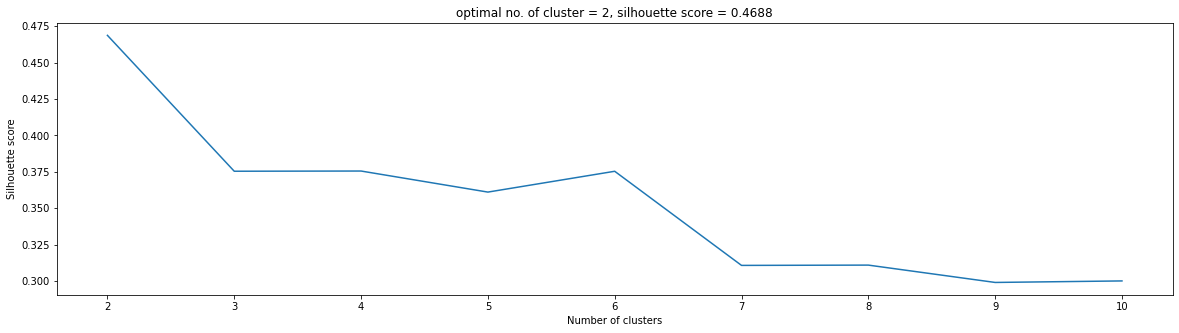

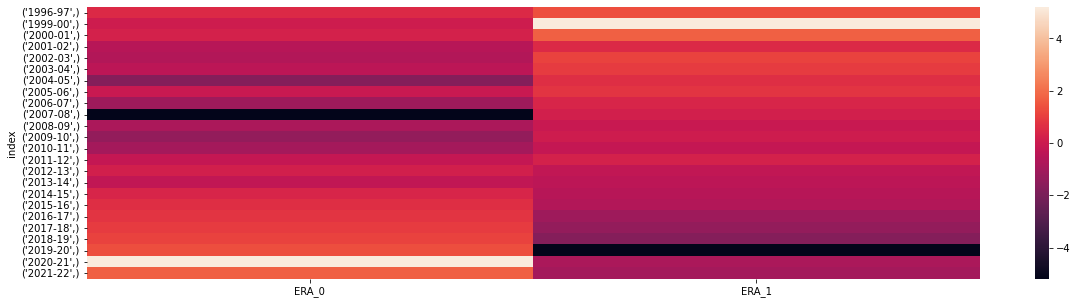

In [28]:
season_prepared = SeasonSimilarity(random_state=42).fit_transform(season, plot_silh = True)
sns.heatmap(season_prepared.loc[:, ["ERA" in x for x in season_prepared.columns]].reset_index().groupby(["index"]).mean())

### Alternative: agglomerative clustering

In [29]:
# from sklearn.cluster import AgglomerativeClustering
# from scipy.cluster.hierarchy import dendrogram

# # create a custom transformer to cluster nba seasons into era
# class SeasonSimilarity2(BaseEstimator, TransformerMixin):
#   def __init__(self, n_clusters = 3, compute_distances = True):
#     self.n_clusters = n_clusters
#     self.compute_distances = compute_distances
  
#   def fit(self, X, y = None, sample_weight = None):
#     # group by season to get league average
#     X_season = X.groupby("SEASON").mean().sort_index()
#     self.feature_names_in_ = X.columns.values
#     self.index_names = X_season.sort_index().index.values
#     self.agg_cluster_ = AgglomerativeClustering(n_clusters=self.n_clusters, compute_distances=self.compute_distances)
#     self.agg_cluster_.fit(X_season)
#     return self
  
#   def transform(self, X):
#     X_season = X.groupby("SEASON").mean().sort_index()
#     X_cluster = pd.DataFrame(self.agg_cluster_.predict(X_season), index = X_season.index, columns=[f"ERA_{i}" for i in range(self.n_clusters)]).reset_index()
#     output = X[["SEASON"]].merge(X_cluster, how = "inner", on = "SEASON")
#     output.drop(columns = ["SEASON"], inplace = True)
#     output.index = X[["SEASON"]]
#     self.output_features = output.columns.values
#     return output
  
#   def get_feature_names_out(self, names = None):
#     return self.output_features

#   def plot_dendrogram(self, **kwargs):
#     model = self.agg_cluster_
#     def create_plot(model, **kwargs):
#       # Create linkage matrix and then plot the dendrogram

#       # create the counts of samples under each node
#       counts = np.zeros(model.children_.shape[0])
#       n_samples = len(model.labels_)
#       for i, merge in enumerate(model.children_):
#           current_count = 0
#           for child_idx in merge:
#               if child_idx < n_samples:
#                   current_count += 1  # leaf node
#               else:
#                   current_count += counts[child_idx - n_samples]
#           counts[i] = current_count

#       linkage_matrix = np.column_stack(
#           [model.children_, model.distances_, counts]
#       )

#       # Plot the corresponding dendrogram
#       dendrogram(linkage_matrix, **kwargs)

#     create_plot(model, truncate_mode="level", p=20)
#     plt.xlabel("Number of points in node (or index of point if no parenthesis).")
#     locs, labels = plt.xticks() 
#     plt.xticks(locs, [season['SEASON'].unique().to_list()[int(x.get_text())] for x in labels])
#     plt.show()

In [30]:
# agg_cluster = SeasonSimilarity2(n_clusters = 3, compute_distances=True).fit(season)
# agg_cluster.plot_dendrogram()

## combine as data_preparation pipeline

In [31]:
# right now only 1 step because we need to incorporate data_cleaning pipeline into SeasonSimilarity 
# but we can add other steps later as well
data_preparation = make_pipeline(
    SeasonSimilarity(random_state=42)
)

data_preparation.fit_transform(season)

,W,L,W_PCT,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,OPP_FGM,OPP_FGA,OPP_FG_PCT,OPP_FG3M,OPP_FG3A,OPP_FG3_PCT,OPP_FTM,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_TOV,OPP_STL,OPP_BLK,OPP_BLKA,OPP_PTS,FG2A,FG2M,FG2_PCT,FG2_FG3,ERA_0,ERA_1
"(1996-97,)",2.048685,-2.918152,2.918152,2.69484,2.455101,1.129225,-0.20667,-0.247427,0.3326,-0.405841,-0.231532,-0.49625,2.55682,-0.442053,1.786962,2.194924,-0.713798,1.453349,-1.217033,-1.869022,-0.379623,0.327939,1.364103,2.918152,-0.685612,0.51128,-1.120915,-0.577828,-0.222476,-2.031015,-1.064788,-0.710954,-1.586279,1.908412,-1.936415,-0.353663,-1.284567,1.705892,-0.157311,-1.869022,-1.217033,-1.563403,1.245282,2.27531,0.588289,0.417851,0.511936,1.359737
"(1996-97,)",0.609409,-1.189724,1.129225,-0.614731,-0.011033,-0.757177,0.466518,0.471444,0.281706,0.523894,0.425085,0.039728,1.358529,0.128331,1.447034,-1.555957,0.887147,0.671722,0.961566,-0.777914,-0.101676,0.883881,0.126106,1.176396,-0.348969,1.634697,-1.453349,-0.14615,0.046354,-0.688406,-1.669237,-1.250087,-1.936415,2.27531,-1.0726,0.798991,0.088376,0.927103,-0.017653,-0.777914,0.961566,-1.347507,-0.434766,-0.826623,-0.451806,-0.466518,0.511936,1.359737
"(1996-97,)",-0.238337,-0.008826,-0.129443,-0.719503,-0.811195,-0.181935,-1.172,-1.176396,-0.486291,1.315386,1.279548,-0.081733,0.954583,-1.922225,-0.786904,0.193163,0.954583,0.461603,2.27531,0.887147,0.897001,0.989982,-0.483809,-0.446924,-0.290901,-0.577828,0.030896,-0.498747,-0.786904,0.947646,0.979233,1.212419,-1.064788,1.734968,-1.150349,0.370154,0.193163,1.472651,0.377253,0.887147,2.27531,-0.030896,0.880624,0.763069,-0.609409,1.158944,0.511936,1.359737
"(1996-97,)",0.864481,-1.347507,1.320645,0.90362,-1.809183,2.148297,-1.336647,-1.512992,0.396276,1.570937,1.479209,0.015446,0.086162,-0.442053,-0.38437,2.55682,1.07653,1.548596,-0.002207,-0.035312,1.869022,1.908412,0.691205,1.506097,-2.013957,-2.067019,-1.163274,-0.14615,0.083947,-1.053191,1.776174,1.9815,-0.69401,0.745473,-2.27531,-1.570937,-1.0726,1.705892,0.506257,-0.035312,-0.002207,-0.913622,0.754241,2.148297,0.877377,1.434574,0.511936,1.359737
"(1996-97,)",-0.923717,0.346625,-0.771955,-1.447034,-0.396276,-1.369719,0.263385,0.186423,0.588289,0.184179,0.408238,-0.808133,1.578562,-1.610016,0.011033,-0.638901,2.067019,1.008155,1.555957,1.20783,1.428427,0.826623,-0.940754,-0.786904,-0.516316,-0.930499,0.030896,-0.327939,-0.245153,-0.55967,1.185258,1.669237,-2.220152,2.50273,-1.578562,0.256538,1.084442,1.705892,1.594092,1.20783,1.555957,-0.008826,-0.249703,-1.068686,-1.410301,-0.222476,0.511936,1.359737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2021-22,)",1.108593,-0.128331,0.562253,0.90362,1.092421,0.229266,1.687281,2.031015,-0.486291,-1.116789,-1.112682,0.261102,-1.07653,1.347507,0.20667,0.802031,-1.634697,-0.702457,-1.104523,-1.669237,-0.64161,-0.546813,1.180815,0.710954,0.598816,0.76012,0.184179,0.944194,1.274561,-1.167626,-1.466157,-1.358529,-0.095024,-1.369719,1.705892,0.620071,0.657961,-0.848559,-1.352998,-1.669237,-1.104523,0.473911,-1.765589,-1.386832,1.669237,-1.88183,1.711675,-0.938814
"(2021-22,)",1.108593,-0.25198,0.622747,1.041734,0.277117,0.965075,1.347507,1.392628,-0.028689,-1.226341,-1.112682,-0.110552,-0.638901,1.410301,0.771955,1.434574,-0.068456,-0.546813,-0.829732,-0.777914,-2.619619,-1.01922,1.022936,0.906944,0.270245,1.548596,-0.564839,1.250087,1.618134,-0.851726,-2.55682,-2.455101,0.064033,-0.339604,0.238337,-0.128331,0.442053,-0.725232,1.116789,-0.777914,-0.829732,0.079519,-1.392628,-1.108593,1.570937,-1.410301,1.711675,-0.938814
"(2021-22,)",1.479209,-0.471444,0.897001,1.908412,0.351315,1.725113,1.146084,0.965075,0.989982,-0.593544,-1.235756,2.126632,-1.618134,0.877377,-0.64161,0.802031,-1.541318,-0.968597,-0.69401,-0.164016,-1.660415,-5.199338,1.797962,0.486291,1.254922,0.76012,0

## (optional) Dimensionality reduction
- advantage
  - PCA can solve the axis orientation issue with decision tree
- disadvantage
  - information loss
  - harder to maintain pipeline as new data comes in
    - assume the current dataset is a random sampling of the underlying population, the PCA components should be stable
- considerations
  - let's not use PCA to allow interpretation of our feature
  - if we need to use decision tree, we can still use random forests or other ensemble methods on top of it
  - but random forest still assign high feature importance to highly correlated features (e.g. W_PCT, W, L)

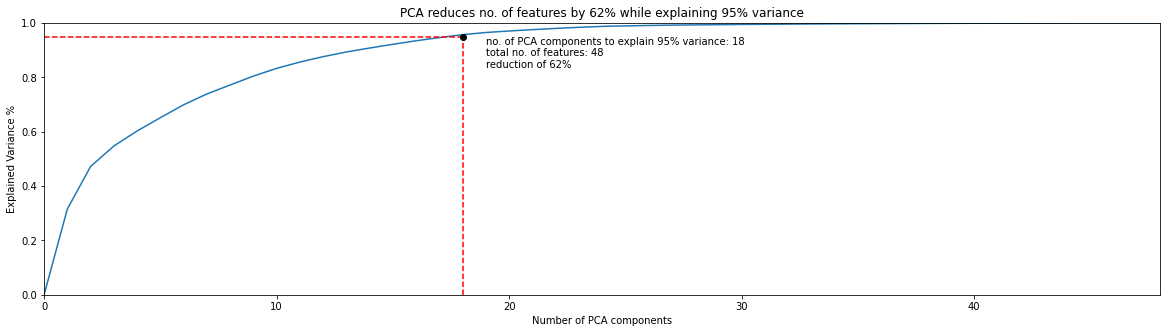

In [32]:
pca = PCA().fit(season_prepared)
pca_cumsum = np.cumsum(pca.explained_variance_ratio_)
# aim for 95% variance explained
target = np.argmax(pca_cumsum >= 0.95) + 1 # python starts counting at 0
plt.plot([*range(0,len(pca_cumsum)+1)], [0, *pca_cumsum])
plt.xlim(0,len(pca_cumsum))
plt.ylim(0,1)
plt.xlabel("Number of PCA components")
plt.ylabel("Explained Variance %")
plt.plot([target, target], [0, 0.95], 'r--')
plt.plot([0, target], [0.95, 0.95], 'r--')
plt.plot(target, 0.95, 'ko')
plt.annotate(f"no. of PCA components to explain 95% variance: {target}\n" + 
             f"total no. of features: {pca.n_features_in_}\n" + 
             f"reduction of {(pca.n_features_in_ - target) / pca.n_features_in_:0.0%}", 
             [target+1, 0.95],
             ha = 'left',
             va = 'top')
plt.title(f"PCA reduces no. of features by {(pca.n_features_in_ - target) / pca.n_features_in_:0.0%} while explaining 95% variance")
plt.show()

In [33]:
# don't add to data_preparation pipeline
# while PCA can help reduce no. of features significantly, reduce training time and avoid axis orientation issues in decision tree, 
# I want to keep features interpretable given the dataset is not too large

# data_preparation.steps.append(
#     ("pca", PCA(n_components=0.95))
# )

In [34]:
# print(f"target no. of features to explain 95% variance = {data_preparation.fit_transform(season).shape[1]}")

## Feature selection with lasso penalty
- use lasso penalty with logistic regression to select useful features
- threshold = hyperparameter to tune

In [35]:
selector = SelectFromModel(
    LogisticRegression(penalty='l1', random_state=42, solver='liblinear'),
    threshold=None # hyperparameter to tune
    ).fit(season_prepared, season_label.reshape(-1,))

In [36]:
# hyperparameter to tune
selector.threshold_

1e-05

In [37]:
# original training set
season.shape

(569, 52)

In [38]:
# reduced no. of features
selector.transform(season_prepared).shape

(569, 22)

In [39]:
# columns dropped
data_preparation.get_feature_names_out()[~selector.get_support()]

array(['W', 'L', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB',
       'REB', 'AST', 'TOV', 'BLK', 'PF', 'PFD', 'OPP_FGM', 'OPP_FG3A',
       'OPP_FTM', 'OPP_OREB', 'OPP_REB', 'OPP_TOV', 'OPP_STL', 'OPP_BLKA',
       'OPP_PTS', 'FG2A', 'FG2M'], dtype=object)

In [40]:
# columns retained
selector.get_feature_names_out()

array(['W_PCT', 'FGM', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'STL', 'BLKA',
       'PTS', 'PLUS_MINUS', 'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3M',
       'OPP_FG3_PCT', 'OPP_FTA', 'OPP_FT_PCT', 'OPP_DREB', 'OPP_AST',
       'OPP_BLK', 'FG2_PCT', 'FG2_FG3', 'ERA_0', 'ERA_1'], dtype=object)

In [41]:
# let's use lasso penalty to reduce number of features while 
data_preparation.steps.append(
    ("selector",
      SelectFromModel(
      LogisticRegression(penalty='l1', random_state=42, solver='liblinear'),
      threshold=None # hyperparameter to tune
      )
    )
)

## Final pipeline = data_preparation



In [42]:
data_preparation

Pipeline(steps=[('seasonsimilarity',
                 SeasonSimilarity(n_clusters=2, random_state=42)),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear')))])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


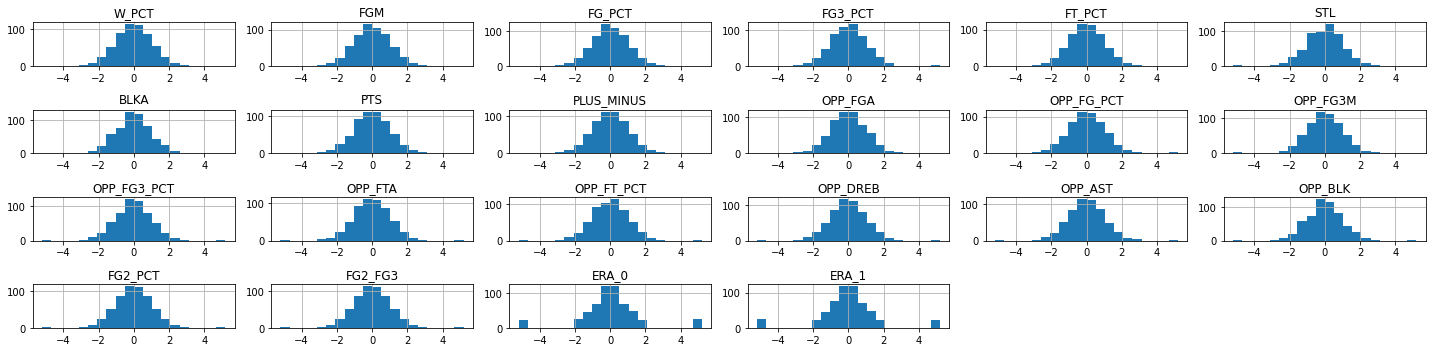

In [43]:
# plot distributions of each feature in X_train
fig, ax = plt.subplots(1,1)
plot_df = pd.DataFrame(data_preparation.fit_transform(season, season_label), 
                       columns = data_preparation.get_feature_names_out()).astype(float)
plot_df.hist(bins = 20, layout = (int(plot_df.shape[1] / 6) + 1, 6),
             ax = ax)
plt.title("Distribution of each feature after cleaning")
plt.tight_layout()

# Shortlist promising models
- missing 
  - analyze most significant variables for each algorithm
  - analyze the type of errors the models make
    - what data would a human to use avoid these errors
  - perform a quick round of feature engineering and selection
  - shortlist models making different types of error

In [44]:
# create a list of models using standard hyperparameters to compare performance
dict_clf = {
    # need predict_proba() for all classifiers such that we can use some ensemble methods later
    # don't use class_weight = 'balanced' as that is equivalent to over-sampling which can emphasize existing bias (if any) in train set
    # think of alternative ways to deal with imbalance data
    # medium article: https://link.medium.com/wJZJhT2o3sb 
    "knn": KNeighborsClassifier(),
    "sgd": SGDClassifier(random_state=42, loss='log', penalty='elasticnet'), # SGD solver for logistic regression
    "logistic": LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', l1_ratio=0.15, max_iter=1000),
    "svc": SVC(kernel='linear', random_state=42, probability=True), # SVC instead of LinearSVC for predict_proba()
    "svc_poly": SVC(kernel='poly', random_state=42, probability=True), # probability=True for predict_proba()
    "svc_rbf": SVC(kernel='rbf', random_state=42, probability=True), # probability=True for predict_proba()
    "tree": DecisionTreeClassifier(random_state=42),
    "forest": RandomForestClassifier(random_state=42),
    "gb": GradientBoostingClassifier(random_state=42),
    "ada": GradientBoostingClassifier(random_state=42, loss='exponential'), # loss='exponential' for AdaBoost
    "xgb": XGBClassifier(random_state=42),
    "xgbrf": XGBRFClassifier(random_state=42)
}

In [45]:
list_clf = []
auc_CVs = []
auc_train = []
list_fpr = []
list_tpr = []

cv = 10

# fit each classification algorithm and calculate 10-fold CV AUC
for key, item in tqdm(dict_clf.items()):
  clf = make_pipeline(data_preparation, item).fit(season, season_label)
  auc_CV = cross_val_score(clf, season, season_label, cv = cv, scoring = 'roc_auc')
  try:
    y_scores = cross_val_predict(clf, season, season_label, cv = cv, method = 'predict_proba')[:,1] # second column = probability of positive class
  # if the classifier does not have decision_function attribute, then use predict_proba
  except AttributeError:
    print(f"{key} doesn't have predict_proba() method")
    y_scores = cross_val_predict(clf, season, season_label, cv = cv, method = 'decision_function')
  
  fpr, tpr, thresholds = roc_curve(season_label, y_scores)

  list_clf.append(key)
  auc_CVs.append(auc_CV)
  auc_train.append(roc_auc_score(season_label, clf.predict_proba(season)[:,1]))
  list_fpr.append(fpr)
  list_tpr.append(tpr)

100%|██████████| 12/12 [06:12<00:00, 31.02s/it]


In [46]:
# sort the models by AUC but not other performance metrics dependent on decision threshold, e.g. precision and recall
mean_auc = [np.mean(auc) for auc in auc_CVs]
sd_auc = [np.std(auc) for auc in auc_CVs]
print("Models sorted by cross validation AUC score")
for mean, sd, clf_name in sorted(zip(mean_auc, sd_auc, list_clf), reverse = True):
  print(f"CV AUC: AVG {mean:0.4f} / SD {sd:0.4f} / {clf_name}")

Models sorted by cross validation AUC score
CV AUC: AVG 0.9118 / SD 0.0524 / xgb
CV AUC: AVG 0.8991 / SD 0.1024 / forest
CV AUC: AVG 0.8936 / SD 0.0889 / logistic
CV AUC: AVG 0.8827 / SD 0.0675 / ada
CV AUC: AVG 0.8627 / SD 0.1051 / svc
CV AUC: AVG 0.8573 / SD 0.0691 / gb
CV AUC: AVG 0.8509 / SD 0.1122 / sgd
CV AUC: AVG 0.8477 / SD 0.1301 / xgbrf
CV AUC: AVG 0.8273 / SD 0.1097 / svc_rbf
CV AUC: AVG 0.7914 / SD 0.1734 / knn
CV AUC: AVG 0.7191 / SD 0.1879 / svc_poly
CV AUC: AVG 0.5514 / SD 0.1067 / tree


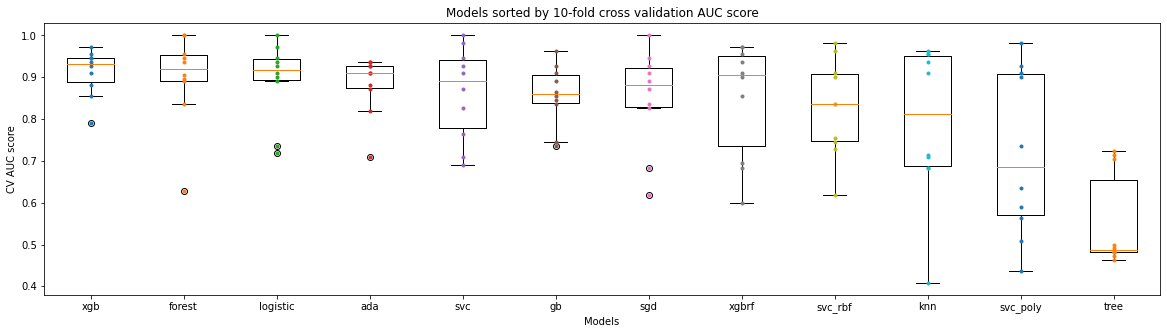

In [47]:
# sort the models and plot the spread of CV AUC scores
mean_auc = [np.mean(auc) for auc in auc_CVs]
sorted_auc_CV = [i for _, i in sorted(zip(mean_auc, auc_CVs), reverse = True)]
sorted_clf = [i for _, i in sorted(zip(mean_auc, list_clf), reverse = True)]
sorted_auc_train = [i for _, i in sorted(zip(mean_auc, auc_train), reverse = True)]
plt.boxplot(sorted_auc_CV, labels=sorted_clf)
# add dots for CV AUC scores
for i, auc in enumerate(sorted_auc_CV):
  plt.plot([i+1]*len(auc), auc, ".")
# plt.plot([*range(1,len(sorted_auc_CV)+1,1)], sorted_auc_train, "ks")
plt.title(f"Models sorted by {cv}-fold cross validation AUC score")
plt.xlabel("Models")
plt.ylabel("CV AUC score")
plt.show()

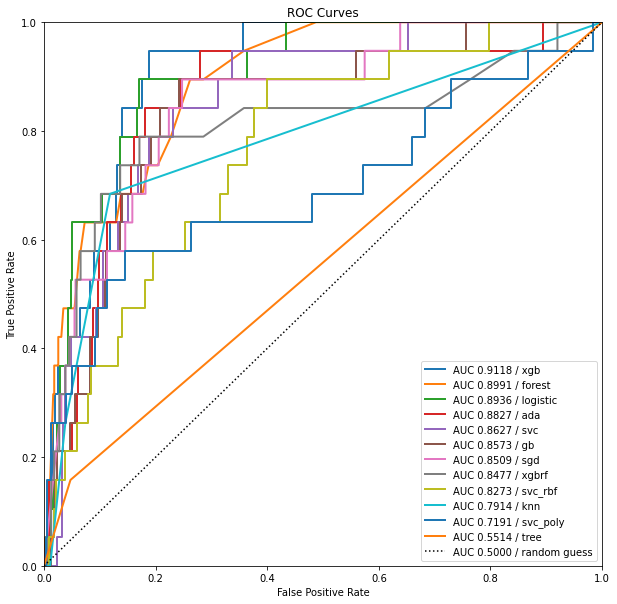

In [48]:
figure(figsize=(10, 10))
for auc, fpr, tpr, clf_name in sorted(zip(mean_auc, list_fpr, list_tpr, list_clf), reverse = True):
  plt.plot(fpr, tpr, linewidth = 2, label = f"AUC {auc:0.4f} / {clf_name}")
plt.plot([0,1], [0,1], 'k:', label = "AUC 0.5000 / random guess")
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Fine-tune hyperparameters of shortlisted models with RandomizedSearchCV

In [49]:
# print top models to tune
top = 6
for name in sorted_clf[:top]:
  print(name, dict_clf[name])

xgb XGBClassifier(random_state=42)
forest RandomForestClassifier(random_state=42)
logistic LogisticRegression(l1_ratio=0.15, max_iter=1000, penalty='elasticnet',
                   random_state=42, solver='saga')
ada GradientBoostingClassifier(loss='exponential', random_state=42)
svc SVC(kernel='linear', probability=True, random_state=42)
gb GradientBoostingClassifier(random_state=42)


In [50]:
# testing reasonable range of hyperparameters before RandomizedSearchCV
expon = False
count = 1
for i in range(1,10**3,10**2):
  if expon:
    count = count * i/10**20 / (i/10**22)
    i = count
  else:
    i = i/10**3
  full_pipeline = make_pipeline(
      data_preparation,
      SGDClassifier(loss='log', penalty='elasticnet', random_state=42, learning_rate = 'invscaling', eta0 = i)
  )

  full_pipeline.fit(season, season_label)
  cv_score = cross_val_score(full_pipeline, season, season_label, cv = 5, scoring='roc_auc')
  auc_train = roc_auc_score(season_label, full_pipeline.predict_proba(season)[:,1])
  print(f"choice {i}, CV AUC {cv_score}")
  print(f"mean AUC {np.mean(cv_score):0.4f}, std AUC {np.std(cv_score):0.4f} / train AUC {auc_train:0.4f}")
  # print(full_pipeline.get_params().keys())
  # plt.hist([np.log2(x) for x in loguniform(a=2**-2, b=2**2).rvs(size=10**6)])

choice 0.001, CV AUC [0.80681818 0.78863636 0.875      0.95       0.75454545]
mean AUC 0.8350, std AUC 0.0696 / train AUC 0.9478
choice 0.101, CV AUC [0.86136364 0.925      0.80681818 0.95227273 0.95454545]
mean AUC 0.9000, std AUC 0.0575 / train AUC 0.9634
choice 0.201, CV AUC [0.86590909 0.91818182 0.8        0.95454545 0.96060606]
mean AUC 0.8998, std AUC 0.0602 / train AUC 0.9632
choice 0.301, CV AUC [0.86818182 0.91818182 0.79772727 0.95227273 0.95151515]
mean AUC 0.8976, std AUC 0.0586 / train AUC 0.9634
choice 0.401, CV AUC [0.87727273 0.90909091 0.79318182 0.95       0.95151515]
mean AUC 0.8962, std AUC 0.0585 / train AUC 0.9630
choice 0.501, CV AUC [0.87727273 0.90909091 0.79318182 0.94772727 0.94545455]
mean AUC 0.8945, std AUC 0.0569 / train AUC 0.9636
choice 0.601, CV AUC [0.87954545 0.90909091 0.79318182 0.94772727 0.93939394]
mean AUC 0.8938, std AUC 0.0558 / train AUC 0.9633
choice 0.701, CV AUC [0.87727273 0.90681818 0.79090909 0.94772727 0.93333333]
mean AUC 0.8912, st

In [51]:
# create a list of hyperparameters to tune for each shortlisted classifier
shortlisted_clfs = {
    "xgb": XGBClassifier(random_state=42),
    "forest": RandomForestClassifier(random_state=42),
    "xgbrf": XGBRFClassifier(random_state=42),
    "logistic": LogisticRegression(random_state=42, penalty='elasticnet', solver='saga', l1_ratio=0.15, max_iter=1000),
    "svc": SVC(kernel='linear', probability=True, max_iter=10**5, random_state=42),
    "sgd": SGDClassifier(random_state=42, penalty='elasticnet', loss='log')
    
}

param_grids = {
    # https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
    "xgb": {
        "xgb__gamma": uniform(loc = 0, scale = 10),
        "xgb__reg_alpha": uniform(loc = 0, scale = 10),
        "xgb__reg_gamma": uniform(loc = 0, scale = 10),
        "xgb__learning_rate": uniform(loc = 0.01, scale = 1),
        "xgb__max_depth": randint(low = 1, high = 5),
        "xgb__min_child_weight": randint(low = 1, high = 30),
    },

    "xgbrf": {
        "xgbrf__gamma": uniform(loc = 0, scale = 10),
        "xgbrf__reg_alpha": uniform(loc = 0, scale = 10),
        "xgbrf__reg_gamma": uniform(loc = 0, scale = 10),
        "xgbrf__learning_rate": uniform(loc = 0.01, scale = 1),
        "xgbrf__max_depth": randint(low = 1, high = 5),
        "xgbrf__min_child_weight": randint(low = 1, high = 30),
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier
    "forest": {
        "forest__max_depth": randint(low = 3, high = 5),
        "forest__min_samples_split": uniform(loc = 0.1, scale = 0.5),
        # "forest__min_samples_leaf": uniform(loc = 0.01, scale = 0.2)
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    "logistic": {
        "logistic__C": loguniform(a = 10**-3, b = 10**-1),
        "logistic__l1_ratio": uniform(loc = 0, scale = 1),
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html?highlight=svc#sklearn.svm.SVC
    "svc": {
        "svc__C": loguniform(a = 10**-20, b = 10**1)
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html?highlight=sgdclassifier#sklearn.linear_model.SGDClassifier
    "sgd": {
        "sgd__l1_ratio": uniform(loc = 0, scale = 1),
        "sgd__alpha": loguniform(a = 10**-3, b = 10**-1),
        "sgd__learning_rate": ['optimal', 'adaptive'],
        "sgd__eta0": loguniform(a = 10**-3, b = 10**-1)
    }
    
}

## Issue with best_estimator_
sklearn returns best_estimator_ at best_index_ = highest mean_test_score 
- but if there is a tie based on mean_test_score, sklearn does not return the one with the lowest std_test_score
- https://github.com/scikit-learn/scikit-learn/blob/db8d67c6a10ef37bf58088e414bbe8a7f7160c60/sklearn/model_selection/_search.py#L1260

In [52]:
random_clfs = []

for clf_name, clf in tqdm(shortlisted_clfs.items()):
  
  full_pipeline = Pipeline([ 
    ("preparation", data_preparation),
    (clf_name, clf)
  ])

  print(clf_name)
  print(clf)
  
  param_grid = copy.deepcopy(param_grids[clf_name])
  # tune C for inverse of regularization strength in lasso penalty for feature selection in data_prepartion pipeline
  param_grid["preparation__selector__estimator__C"] = loguniform(a = 10**0, b = 10**1)
  
  print(param_grid)

  random_search = RandomizedSearchCV(full_pipeline, 
                                    param_grid, 
                                    cv = 10, 
                                    n_iter = 100, 
                                    scoring = "roc_auc",
                                    random_state = 42,
                                    n_jobs = -1,
                                    error_score = 'raise')

  random_search.fit(season, season_label)
  random_clfs.append(random_search)

  print(f"\nbest_score: {random_search.best_score_}")
  print(f"best_params: {random_search.best_params_}")
  # print(pd.DataFrame(random_search.cv_results_))

  0%|          | 0/6 [00:00<?, ?it/s]

xgb
XGBClassifier(random_state=42)
{'xgb__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f589d000090>, 'xgb__reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a11fd4d0>, 'xgb__reg_gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a11fd210>, 'xgb__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a11fd750>, 'xgb__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a11fdfd0>, 'xgb__min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a11fdf90>, 'preparation__selector__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a11fd950>}


 17%|█▋        | 1/6 [13:08<1:05:43, 788.62s/it]


best_score: 0.9090909090909092
best_params: {'preparation__selector__estimator__C': 2.655962930461066, 'xgb__gamma': 9.06354385094736, 'xgb__learning_rate': 0.12119748230615134, 'xgb__max_depth': 3, 'xgb__min_child_weight': 13, 'xgb__reg_alpha': 0.11353644767419069, 'xgb__reg_gamma': 4.6866064199412625}
forest
RandomForestClassifier(random_state=42)
{'forest__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a1319650>, 'forest__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a1319c90>, 'preparation__selector__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a0c7ff50>}


 33%|███▎      | 2/6 [27:33<55:33, 833.27s/it]  


best_score: 0.9409090909090908
best_params: {'forest__max_depth': 3, 'forest__min_samples_split': 0.4049983288913105, 'preparation__selector__estimator__C': 6.810749571374121}
xgbrf
XGBRFClassifier(random_state=42)
{'xgbrf__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a1310290>, 'xgbrf__reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a1310d50>, 'xgbrf__reg_gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a11a3850>, 'xgbrf__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a11a3b90>, 'xgbrf__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a11a3290>, 'xgbrf__min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a11a3990>, 'preparation__selector__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a1310dd0>}


 50%|█████     | 3/6 [40:28<40:20, 806.70s/it]


best_score: 0.9204545454545455
best_params: {'preparation__selector__estimator__C': 6.74120461070276, 'xgbrf__gamma': 3.567533266935893, 'xgbrf__learning_rate': 0.29093450968738077, 'xgbrf__max_depth': 4, 'xgbrf__min_child_weight': 13, 'xgbrf__reg_alpha': 1.4092422497476265, 'xgbrf__reg_gamma': 8.021969807540398}
logistic
LogisticRegression(l1_ratio=0.15, max_iter=1000, penalty='elasticnet',
                   random_state=42, solver='saga')
{'logistic__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a17e5050>, 'logistic__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a17e50d0>, 'preparation__selector__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a1221910>}


 67%|██████▋   | 4/6 [53:51<26:50, 805.42s/it]


best_score: 0.949090909090909
best_params: {'logistic__C': 0.005499426480345607, 'logistic__l1_ratio': 0.015456616528867428, 'preparation__selector__estimator__C': 8.478490982264661}
svc
SVC(kernel='linear', max_iter=100000, probability=True, random_state=42)
{'svc__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a118b590>, 'preparation__selector__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a118be50>}


 83%|████████▎ | 5/6 [1:06:15<13:03, 783.17s/it]


best_score: 0.8909090909090909
best_params: {'preparation__selector__estimator__C': 5.764810670114667, 'svc__C': 6.120982656645309e-09}
sgd
SGDClassifier(loss='log', penalty='elasticnet', random_state=42)
{'sgd__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a119e450>, 'sgd__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a119e510>, 'sgd__learning_rate': ['optimal', 'adaptive'], 'sgd__eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a119e7d0>, 'preparation__selector__estimator__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f58a17c6890>}


100%|██████████| 6/6 [1:18:37<00:00, 786.33s/it]


best_score: 0.9445454545454546
best_params: {'preparation__selector__estimator__C': 4.226099034493719, 'sgd__alpha': 0.04373747301510568, 'sgd__eta0': 0.020089519235134704, 'sgd__l1_ratio': 0.20668435987674538, 'sgd__learning_rate': 'optimal'}


In [53]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


In [54]:
for i, random_clf in enumerate(random_clfs):
  print(f'model{i} {random_clf.best_estimator_.steps[1][0]} dumped')
  dump(random_clf, f'model{i}_tuned.joblib') 

model0 xgb dumped
model1 forest dumped
model2 xgbrf dumped
model3 logistic dumped
model4 svc dumped
model5 sgd dumped


## Check model performance after hyperparameter tuning

In [55]:
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
tuned_models = {}
for file in [x for x in os.listdir() if '_tuned.joblib' in x]:
  model = load(file)
  tuned_models[model.best_estimator_.steps[1][0]] = model
  print(model.best_estimator_.steps[1][0], "loaded")

xgb loaded
sgd loaded
forest loaded
xgbrf loaded
svc loaded
logistic loaded


In [57]:
# pull the CV AUC results from RandomizedSearchCV
tuned_auc = []
for clf_name, model in tuned_models.items():
  # tuned_auc.append(cross_val_score(model.best_estimator_, season, season_label, cv = 10, scoring='roc_auc'))
  cv_auc_colindex = [i for i, x in enumerate(model.cv_results_.keys()) if re.search('split\w+_test_score', x) is not None]
  tuned_auc.append(pd.DataFrame(model.cv_results_).iloc[model.best_index_,cv_auc_colindex].values)

In [58]:
# sort the models and plot the spread of CV AUC scores
mean_tuned_auc = [np.mean(auc) for auc in tuned_auc]
mean_train_auc = [roc_auc_score(season_label, model.best_estimator_.predict_proba(season)[:,1]) for _, model in tuned_models.items()]
sorted_tuned_auc = [i for _, i in sorted(zip(mean_tuned_auc, tuned_auc), reverse = True)]
sorted_tuned_clf = [i for _, i in sorted(zip(mean_tuned_auc, tuned_models.keys()), reverse = True)]
sorted_train_auc = [i for _, i in sorted(zip(mean_tuned_auc, mean_train_auc), reverse = True)]

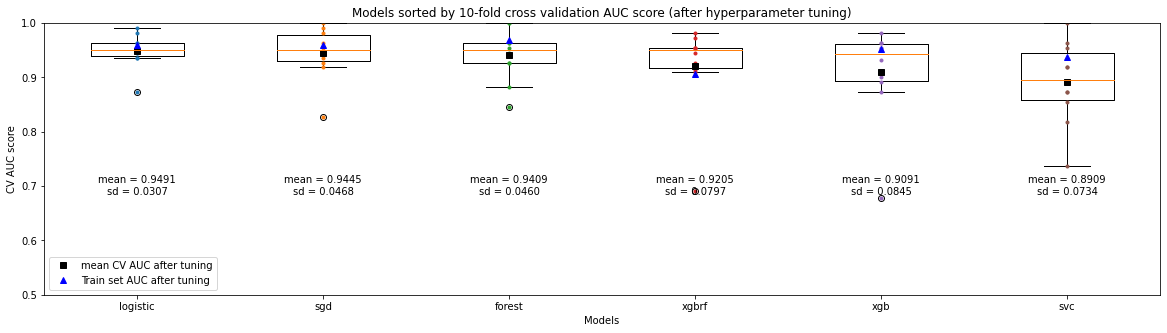

In [59]:
plt.boxplot(sorted_tuned_auc, labels=sorted_tuned_clf)
# add dots for CV AUC scores
for i, auc in enumerate(sorted_tuned_auc):
  plt.plot([i+1]*len(auc), auc, ".")
  plt.annotate(f"mean = {np.mean(auc):0.4f}\nsd = {np.std(auc):0.4f}",(i+1, 0.7), ha = 'center', va = 'center')

plt.plot([*range(1,len(sorted_tuned_auc)+1,1)], sorted(mean_tuned_auc, reverse=True), 
         "ks", label = 'mean CV AUC after tuning')
plt.plot([*range(1,len(sorted_tuned_auc)+1,1)], sorted_train_auc, 
         "b^", label = 'Train set AUC after tuning')
# plt.plot([*range(1,len(sorted_tuned_auc)+1,1)], [mean_auc[list_clf.index(x)] for x in sorted_tuned_clf], 
#          "k^", label = 'mean CV AUC before tuning')
plt.legend()
plt.title(f"Models sorted by 10-fold cross validation AUC score (after hyperparameter tuning)")
plt.xlabel("Models")
plt.ylim(0.5,1)
plt.ylabel("CV AUC score")
plt.show()

# Ensemble methods
- Combining tuned models with ensemble learning didn't give a better CV result 

In [60]:
# get performance from adaboost and bagging ensemble methods on each tuned model
single_clf_ensemble_models = {
    "Adaboost": AdaBoostClassifier(random_state = 42),
    "Bagging": BaggingClassifier(random_state = 42, n_estimators=50)
}

for ensemble_key, ensemble_model in single_clf_ensemble_models.items():
  for model in sorted_tuned_clf:
    ensemble_model.base_estimator = tuned_models[model].best_estimator_.steps[1][1]
    ensemble_pipeline = make_pipeline(
        data_preparation,
        ensemble_model
    )
    ensemble_pipeline.fit(season, season_label)
    cv_score = cross_val_score(ensemble_pipeline, season, season_label, cv = 10, scoring = 'roc_auc')
    print(f"mean AUC = {np.mean(cv_score):0.4f}, std AUC = {np.std(cv_score):0.4f}, {ensemble_key} {model}")

mean AUC = 0.5000, std AUC = 0.0000, Adaboost logistic
mean AUC = 0.5000, std AUC = 0.0000, Adaboost sgd
mean AUC = 0.9182, std AUC = 0.0600, Adaboost forest
mean AUC = 0.5000, std AUC = 0.0000, Adaboost xgbrf
mean AUC = 0.5000, std AUC = 0.0000, Adaboost xgb
mean AUC = 0.9364, std AUC = 0.0589, Adaboost svc
mean AUC = 0.9382, std AUC = 0.0590, Bagging logistic
mean AUC = 0.9373, std AUC = 0.0577, Bagging sgd
mean AUC = 0.9155, std AUC = 0.0746, Bagging forest
mean AUC = 0.9050, std AUC = 0.0900, Bagging xgbrf
mean AUC = 0.9168, std AUC = 0.0618, Bagging xgb
mean AUC = 0.9036, std AUC = 0.0768, Bagging svc


In [61]:
# get performance from voting and stacking ensemble methods on an increasing basket of tuned models
multiple_clf_ensemble_models = {
    "Voting": VotingClassifier(voting = 'soft', estimators = []),
    "Stacking": StackingClassifier(cv = 10, final_estimator=RandomForestClassifier(random_state=43), estimators = [])
}

for ensemble_key, ensemble_model in multiple_clf_ensemble_models.items():
  for i in range(1,len(tuned_models)):
    ensemble_model.estimators = [(model, tuned_models[model].best_estimator_.steps[1][1]) for model in sorted_tuned_clf[:(i+1)]]
    ensemble_pipeline = make_pipeline(
        data_preparation,
        ensemble_model
    )
    ensemble_pipeline.fit(season, season_label)
    cv_score = cross_val_score(ensemble_pipeline, season, season_label, cv = 10, scoring = 'roc_auc')
    print(f"mean AUC = {np.mean(cv_score):0.4f}, std AUC = {np.std(cv_score):0.4f}, {ensemble_key} {[model for model in sorted_tuned_clf[:(i+1)]]}")

mean AUC = 0.9400, std AUC = 0.0607, Voting ['logistic', 'sgd']
mean AUC = 0.9300, std AUC = 0.0654, Voting ['logistic', 'sgd', 'forest']
mean AUC = 0.9300, std AUC = 0.0651, Voting ['logistic', 'sgd', 'forest', 'xgbrf']
mean AUC = 0.9264, std AUC = 0.0619, Voting ['logistic', 'sgd', 'forest', 'xgbrf', 'xgb']
mean AUC = 0.9118, std AUC = 0.0893, Voting ['logistic', 'sgd', 'forest', 'xgbrf', 'xgb', 'svc']
mean AUC = 0.9073, std AUC = 0.0786, Stacking ['logistic', 'sgd']
mean AUC = 0.9282, std AUC = 0.0575, Stacking ['logistic', 'sgd', 'forest']
mean AUC = 0.9259, std AUC = 0.0580, Stacking ['logistic', 'sgd', 'forest', 'xgbrf']
mean AUC = 0.9155, std AUC = 0.0663, Stacking ['logistic', 'sgd', 'forest', 'xgbrf', 'xgb']
mean AUC = 0.9114, std AUC = 0.0627, Stacking ['logistic', 'sgd', 'forest', 'xgbrf', 'xgb', 'svc']
